In [1]:
import os
import sys
import numpy as np
import pandas as pd
import cv2 as cv
import tensorflow as tf
from tensorflow import keras

import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split

In [2]:
# Tensorflow version
print(f"Python version: {sys.version}")
print(f"Tensorflow version: {tf.__version__}")
print(f"Keras version: {keras.__version__}")

Python version: 3.7.4 (default, Aug  9 2019, 18:34:13) [MSC v.1915 64 bit (AMD64)]
Tensorflow version: 2.0.0
Keras version: 2.2.4-tf


In [3]:
# Limit the GPU memory to VRAM = 5GB in order to avoide cuDNN initialization problem
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        tf.config.experimental.set_virtual_device_configuration(gpus[0], 
        [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=6144)])
    except RuntimeError as e:
        print(e)

## Working directory

In [4]:
cwd = os.getcwd()
train_dir = os.path.join(cwd,'train')
test_dir = os.path.join(cwd,'test')

## Training and testing data

In [5]:
train = pd.read_csv(os.path.join(cwd,'train.csv'))
test = pd.read_csv(os.path.join(cwd,'test.csv'))
train.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge,diagnosis,benign_malignant,target
0,ISIC_2637011,IP_7279968,male,45.0,head/neck,unknown,benign,0
1,ISIC_0015719,IP_3075186,female,45.0,upper extremity,unknown,benign,0
2,ISIC_0052212,IP_2842074,female,50.0,lower extremity,nevus,benign,0
3,ISIC_0068279,IP_6890425,female,45.0,head/neck,unknown,benign,0
4,ISIC_0074268,IP_8723313,female,55.0,upper extremity,unknown,benign,0


In [6]:
test.head()

,image_name,patient_id,sex,age_approx,anatom_site_general_challenge
0,ISIC_0052060,IP_3579794,male,70.0,NaN
1,ISIC_0052349,IP_7782715,male,40.0,lower extremity
2,ISIC_0058510,IP_7960270,female,55.0,torso
3,ISIC_0073313,IP_6375035,female,50.0,torso
4,ISIC_0073502,IP_0589375,female,45.0,lower extremity


In [7]:
# Total training data in the ISIC dataset
train.shape[0]

33126

In [8]:
test.shape[0]

10982

In [9]:
# How many benign vs malignan images available?
train['target'].value_counts()

0    32542
1      584
Name: target, dtype: int64

## Data loading pipeline

In [10]:
# Considering the imbalance in data, take a sample of the set for training with a better balance
df_0=train[train['target']==0].sample(2000)
df_1=train[train['target']==1]
train=pd.concat([df_0,df_1])
train=train.reset_index()

In [11]:
# Process the labels to associate with the training images
labels=[]
train_data=[]
for i in range(train.shape[0]):
    train_data.append(train_dir + '\\' + train['image_name'].iloc[i]+'.jpg')
    labels.append(train['target'].iloc[i])
df_train=pd.DataFrame(train_data)
df_train.columns=['images'] # name this column containing '/dir/../filename' to 'images'
df_train['target']=labels

In [12]:
df_train.head()

,images,target
0,C:\Users\rabbi\ComputerVision\Melanoma_classif...,0
1,C:\Users\rabbi\ComputerVision\Melanoma_classif...,0
2,C:\Users\rabbi\ComputerVision\Melanoma_classif...,0
3,C:\Users\rabbi\ComputerVision\Melanoma_classif...,0
4,C:\Users\rabbi\ComputerVision\Melanoma_classif...,0


In [13]:
df_train['target'].value_counts()

0    2000
1     584
Name: target, dtype: int64

Class: Benign


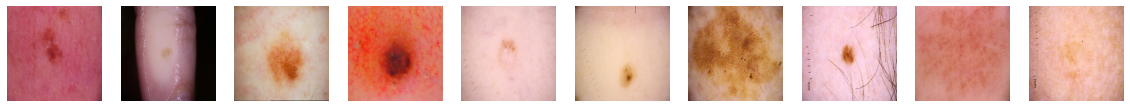

In [14]:
# Visualize the benign vs malignan images
print('Class: Benign')
benign = []
df_benign = train[train['target']==0].sample(10)
df_benign = df_benign.reset_index()
for i in range(10):
    img = cv.imread(str(train_dir+'\\'+df_benign['image_name'].iloc[i]+'.jpg'))
    img = cv.resize(img, (224,224))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.0
    benign.append(img)
f, ax = plt.subplots(1,10, figsize=(20,20))
for i, img in enumerate(benign):
        ax[i].imshow(img)
        ax[i].axis('off')
        
plt.show()

Class: Malignant


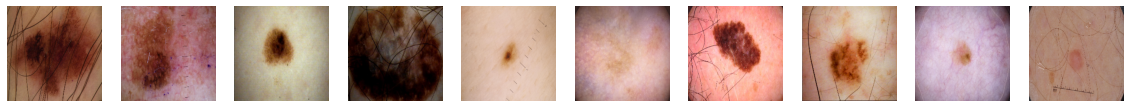

In [15]:
# 
print('Class: Malignant')
malignant=[]
df_malignant=train[train['target']==1].sample(10)
df_malignant=df_malignant.reset_index()
for i in range(10):
    img  =cv.imread(str(train_dir + '\\' + df_malignant['image_name'].iloc[i]+'.jpg'))
    img = cv.resize(img, (224,224))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.0
    malignant.append(img)
f, ax = plt.subplots(1,10, figsize=(20,20))
for i, img in enumerate(malignant):
        ax[i].imshow(img)
        ax[i].axis('off')
        
plt.show()

In [14]:
test_data=[]
for i in range(test.shape[0]):
    test_data.append(test_dir + '\\' + test['image_name'].iloc[i]+'.jpg')
df_test=pd.DataFrame(test_data)
df_test.columns=['images']

In [15]:
df_test.head()

,images
0,C:\Users\rabbi\ComputerVision\Melanoma_classif...
1,C:\Users\rabbi\ComputerVision\Melanoma_classif...
2,C:\Users\rabbi\ComputerVision\Melanoma_classif...
3,C:\Users\rabbi\ComputerVision\Melanoma_classif...
4,C:\Users\rabbi\ComputerVision\Melanoma_classif...


In [16]:
# Split the training dataset into 80/20 : training/validation
# X - training samlples; y - labels
X_train, X_val, y_train, y_val = train_test_split(df_train['images'],df_train['target'], test_size=0.2, random_state=0)

# training dataframe with labels
training = pd.DataFrame(X_train)
training.columns = ['images']
training['target'] = y_train

# validation dataframe with labels
validation=pd.DataFrame(X_val)
validation.columns=['images']
validation['target']=y_val

In [17]:
training.value_counts()

images                                                                        target
C:\Users\rabbi\ComputerVision\Melanoma_classification\train\ISIC_9999127.jpg  0         1
C:\Users\rabbi\ComputerVision\Melanoma_classification\train\ISIC_3490992.jpg  0         1
C:\Users\rabbi\ComputerVision\Melanoma_classification\train\ISIC_3328736.jpg  0         1
C:\Users\rabbi\ComputerVision\Melanoma_classification\train\ISIC_3336297.jpg  0         1
C:\Users\rabbi\ComputerVision\Melanoma_classification\train\ISIC_3338629.jpg  1         1
                                                                                       ..
C:\Users\rabbi\ComputerVision\Melanoma_classification\train\ISIC_6807441.jpg  0         1
C:\Users\rabbi\ComputerVision\Melanoma_classification\train\ISIC_6807667.jpg  0         1
C:\Users\rabbi\ComputerVision\Melanoma_classification\train\ISIC_6808133.jpg  0         1
C:\Users\rabbi\ComputerVision\Melanoma_classification\train\ISIC_6809329.jpg  0         1
C:\Users\rabbi\

In [18]:
validation.value_counts()

images                                                                        target
C:\Users\rabbi\ComputerVision\Melanoma_classification\train\ISIC_9956744.jpg  0         1
C:\Users\rabbi\ComputerVision\Melanoma_classification\train\ISIC_4162774.jpg  0         1
C:\Users\rabbi\ComputerVision\Melanoma_classification\train\ISIC_3478491.jpg  0         1
C:\Users\rabbi\ComputerVision\Melanoma_classification\train\ISIC_3486683.jpg  0         1
C:\Users\rabbi\ComputerVision\Melanoma_classification\train\ISIC_3490353.jpg  0         1
                                                                                       ..
C:\Users\rabbi\ComputerVision\Melanoma_classification\train\ISIC_6745477.jpg  0         1
C:\Users\rabbi\ComputerVision\Melanoma_classification\train\ISIC_6809586.jpg  1         1
C:\Users\rabbi\ComputerVision\Melanoma_classification\train\ISIC_6813799.jpg  0         1
C:\Users\rabbi\ComputerVision\Melanoma_classification\train\ISIC_6829008.jpg  1         1
C:\Users\rabbi\

In [19]:
IMG_HEIGHT = 224
IMG_WIDTH = 224

In [20]:
# Training and validation data generator using Keras tool
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# training data generator - data normalization, resize, and augmentation
train_data_gen = ImageDataGenerator(rescale=1./255, rotation_range=90, width_shift_range=0.2, height_shift_range=0.2,
                                    horizontal_flip=True, vertical_flip=True)

training_generator = train_data_gen.flow_from_dataframe(
    training,
    x_col='images',
    y_col='target',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=8,
    shuffle=True,
    class_mode='raw') 

# validation data generator - normalization and resize 
val_datagen=ImageDataGenerator(rescale=1./255)
validation_generator = val_datagen.flow_from_dataframe(
    validation,
    x_col='images',
    y_col='target',
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=False,
    batch_size=8,
    class_mode='raw')

Found 2067 validated image filenames.
Found 517 validated image filenames.


In [171]:
#x,y = next(iter(training_generator))
#x,y

In [172]:
#w,z = next(iter(validation_generator))
#w,z

## Model creation

In [ ]:
MODELS = {
    "vgg16": VGG16,
    "vgg19": VGG19,
    "inception": InceptionV3,
    "xception": Xception, # This notebook works with this one only
    "resnet": ResNet50
}

In [25]:
def make_model(output_bias = None, metrics = None):    
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
        
    base_model = tf.keras.applications.Xception(input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
                                                include_top=False,
                                                weights='imagenet')
    
    base_model.trainable = False
    
    model = tf.keras.Sequential([
        base_model,
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(8, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid',
                              bias_initializer=output_bias)
    ])
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=metrics)
    
    return model

The following function allows for the model to optimally change the learning rate as it runs each epoch. Having a learning rate that is too high could prevent converging. However, having a learning rate that is too small will take too long too converge. Using this function, the model will know how to change its learning rate after each epoch and update the learning rate itself to allow for increased efficiency while still allowing the model to converge [3].

In [26]:
def exponential_decay(lr0, s):
    def exponential_decay_fn(epoch):
        return lr0 * 0.1 **(epoch / s)
    return exponential_decay_fn

exponential_decay_fn = exponential_decay(0.01, 20)

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(exponential_decay_fn)

There are only 1.7 % malignant images are in the dataset. Hence, we introduce a bias measurement. 

In [27]:
benign = 32542
malignant = 584
total_img = benign + malignant
initial_bias = np.log([malignant/benign])
initial_bias

array([-4.02038586])

Since there are not enough malignant images, we want these malignant images to have more weight in our model. By increasing the weight of these malignant images, the model will pay more attention to them, and this will help balance out the difference in quantity [3].

In [28]:
weight_for_0 = (1 / benign)*(total_img)/2.0 
weight_for_1 = (1 / malignant)*(total_img)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.51
Weight for class 1: 28.36


In [ ]:
model = make_model(output_bias = initial_bias, metrics=[tf.keras.metrics.AUC(name='auc')])

In [ ]:
# Model summary
model.summary()

In [100]:
checkpoint_cb = tf.keras.callbacks.ModelCheckpoint("model_xception.h5", verbose=1, save_best_only=True)

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.01, patience=5, restore_best_weights=True)

In [101]:
# train the model
batch_size = 8
epochs = 10

train_steps = training.shape[0]//batch_size
val_steps = validation.shape[0]//batch_size
  
history = model.fit_generator(
    training_generator,
    steps_per_epoch = train_steps,
    epochs = epochs,
    validation_data = validation_generator,
    validation_steps = val_steps,
    callbacks = [checkpoint_cb, early_stopping_cb, lr_scheduler],
    class_weight = class_weight
)

Epoch 1/10
207/208 [============================>.] - ETA: 1s - loss: 3.8607 - auc: 0.5385
Epoch 00001: val_loss improved from inf to 1.20481, saving model to model_xception.h5
208/208 [==============================] - 318s 2s/step - loss: 3.8563 - auc: 0.5393 - val_loss: 1.2048 - val_auc: 0.7478
Epoch 2/10
207/208 [============================>.] - ETA: 1s - loss: 2.2437 - auc: 0.6497
Epoch 00002: val_loss did not improve from 1.20481
208/208 [==============================] - 306s 1s/step - loss: 2.2373 - auc: 0.6510 - val_loss: 1.2998 - val_auc: 0.6869
Epoch 3/10
207/208 [============================>.] - ETA: 1s - loss: 2.5217 - auc: 0.5859
Epoch 00003: val_loss improved from 1.20481 to 0.74932, saving model to model_xception.h5
208/208 [==============================] - 303s 1s/step - loss: 2.5197 - auc: 0.5860 - val_loss: 0.7493 - val_auc: 0.7352
Epoch 4/10
207/208 [============================>.] - ETA: 1s - loss: 1.6967 - auc: 0.6790
Epoch 00004: val_loss did not improve from 

## Inspect accuracy and loss

In [102]:
import plotly.graph_objects as go
# plot accuracy
fig = go.Figure()

fig.add_trace(go.Scatter(x=history.epoch,
                         y=history.history['auc'],
                         mode='lines+markers',
                         name='Training accuracy'))
fig.add_trace(go.Scatter(x=history.epoch,
                         y=history.history['val_auc'],
                         mode='lines+markers',
                         name='Validation accuracy'))
fig.update_layout(title='Accuracy',
                  xaxis=dict(title='Epoch'),
                  yaxis=dict(title='Percentage'))
fig.show()

In [103]:
fig = go.Figure()
# plot loss
fig.add_trace(go.Scatter(x=history.epoch,
                         y=history.history['loss'],
                         mode='lines+markers',
                         name='Training loss'))
fig.add_trace(go.Scatter(x=history.epoch,
                         y=history.history['val_loss'],
                         mode='lines+markers',
                         name='Validation loss'))
fig.update_layout(title='Loss',
                  xaxis=dict(title='Epoch'),
                  yaxis=dict(title='Percentage'))
fig.show()

## Save the model 

In [67]:
model.save_weights(os.path.join(cwd, 'melanoma_xception'))

## Test the model - make inference

In [136]:
from tensorflow.keras.models import load_model
model = load_model('model_xception.h5')

In [109]:
path = r"C:\Users\rabbi\ComputerVision\Melanoma_classification\test\ISIC_9998682.jpg"
img = cv.imread(path)
img = cv.resize(img, (224, 224)) # resize to (224, 224, 3)
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
img = img.astype(np.float32)/255.0
img = np.reshape(img,[1,224,224,3]) # numpy array of shape [w, x, y, z], w represents number of image
pred = model.predict(img) # probabilities
pred
# img = cv2.imread('test.jpg')

array([[0.27098635]], dtype=float32)

In [110]:
# Apply prediction with a fitted model to the test dataset without label
target=[]
for path in df_test['images']:
    img = cv.imread(str(path))
    img = cv.resize(img, (IMG_HEIGHT, IMG_WIDTH))
    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
    img = img.astype(np.float32)/255.0
    img = np.reshape(img,(1,224,224,3))
    pred = model.predict(img) # Array of lists. Where the inner list is the probability of an instance belonging to each class.    
    target.append(pred[0][0])

In [111]:
# Save the predictions to csv file 
submission = pd.read_csv(os.path.join(cwd,"sample_submission.csv"))                                  
submission["target"] = target
submission.to_csv("submission.csv", index=False)
submission.head()

,image_name,target
0,ISIC_0052060,0.081427
1,ISIC_0052349,0.306068
2,ISIC_0058510,0.768261
3,ISIC_0073313,0.506441
4,ISIC_0073502,0.957914


In [112]:
submission.tail()

,image_name,target
10977,ISIC_9992485,0.746809
10978,ISIC_9996992,0.697816
10979,ISIC_9997917,0.941527
10980,ISIC_9998234,0.104629
10981,ISIC_9999302,0.854854


### Reference
1. https://www.kaggle.com/c/siim-isic-melanoma-classification/overview
2. https://www.kaggle.com/ibtesama/siim-baseline-keras-vgg16
3. https://www.kaggle.com/amyjang/tensorflow-transfer-learning-melanoma
4. https://towardsdatascience.com/review-xception-with-depthwise-separable-convolution-better-than-inception-v3-image-dc967dd42568